# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

In [1]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU
# 2. Run this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py -O tiny_img.py

--2019-07-03 11:52:44--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3378 (3.3K) [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]   3.30K  --.-KB/s    in 0s      

2019-07-03 11:52:44 (32.8 MB/s) - ‘tiny_img.py’ saved [3378/3378]



# Tiny ImageNet dataset
This week, we shall focus on the image recognition problem on Tiny Image Net dataset
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshoppers, gulls, etc.


In [2]:
import os
import torch, torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tiny_img import download_tinyImg200
if not os.path.exists('./tiny-imagenet-200/'):
    download_tinyImg200('.')
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

./tiny-imagenet-200.zip


In [0]:
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transforms.ToTensor())
test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/val', transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])
test_dataset, val_dataset = torch.utils.data.random_split(val_dataset, [10000, 10000])

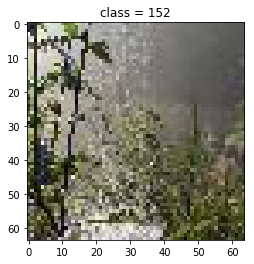

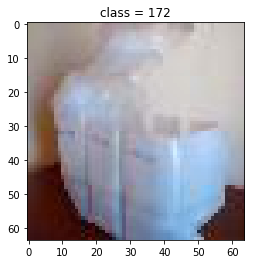

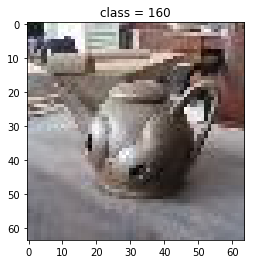

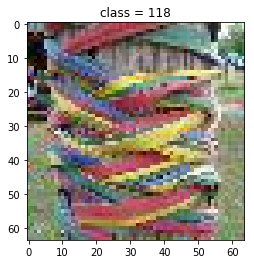

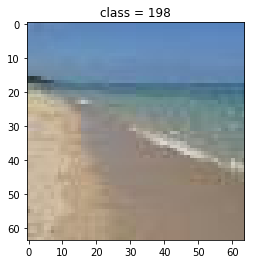

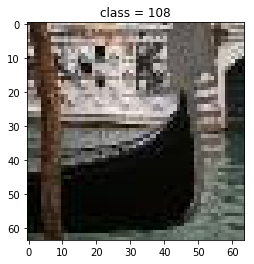

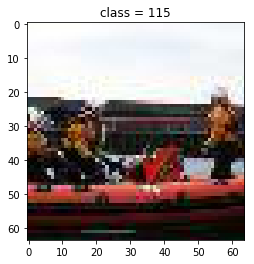

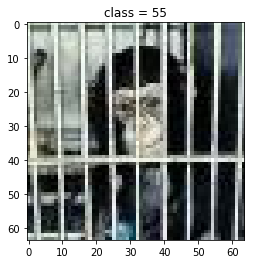

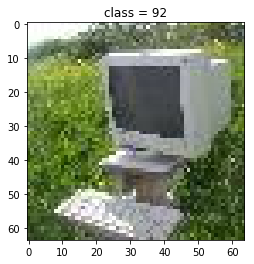

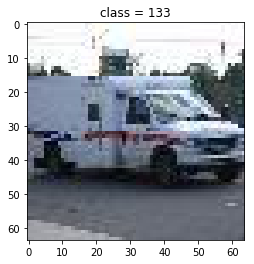

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(10):
    xi, yi = train_dataset[i]
    plt.imshow(xi.data.numpy().transpose(1, 2, 0))
    plt.title('class = %i' % yi)
    plt.show()

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

Let's start with a dense network for our baseline:

In [0]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 64 * 64, 1064))
model.add_module('dense2', nn.Linear(1064, 512))
model.add_module('dropout0', nn.Dropout(0.05)) 
model.add_module('dense3', nn.Linear(512, 256))
model.add_module('dropout1', nn.Dropout(0.05))
model.add_module('dense4', nn.Linear(256, 64))
model.add_module('dropout2', nn.Dropout(0.05))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 200)) # logits for 200 classes

model = model.to(device=device)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32, device=device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64, device=device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

### Training on minibatches
* We got 100k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [0]:
import numpy as np
import time

num_epochs = 100    # total number of full passes over data until training finishes
batch_size = 64     # number of images in one minibatch

for epoch in range(100):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
        logits = model(torch.as_tensor(X_batch, device=device, dtype=torch.float32))
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

Epoch 1 of 100 took 53.958s
  training loss (in-iteration): 	5.295683
  validation accuracy: 			0.81 %
Epoch 2 of 100 took 52.479s
  training loss (in-iteration): 	5.262895
  validation accuracy: 			1.20 %


Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [0]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []

for X_batch, y_batch in DataLoader(test_dataset, batch_size=batch_size):
    logits = model(torch.as_tensor(X_batch, device='cuda', dtype=torch.float32))
    y_pred = logits.max(1)[1].data
    test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))


test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 70:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 40:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 20:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

NameError: name 'DataLoader' is not defined

## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 128 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 1024 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __16%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

In [0]:
model = nn.Sequential()

<describe convnet here>

model.add_module('dense1_logits', nn.Linear(<...>, 200)) # logits for 200 classes

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [0]:
from torchsummary import summary
summary(model.cuda(), (3, 64, 64))

## Train it ##

In [0]:
num_epochs = 100    # total number of full passes over data until training finishes
batch_size = 64     # number of images in one minibatch

for epoch in range(100):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
        logits = model(torch.as_tensor(X_batch, device=device, dtype=torch.float32))
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

In [0]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []

for X_batch, y_batch in DataLoader(test_dataset, batch_size=batch_size):
    logits = model(torch.as_tensor(X_batch, device='cuda', dtype=torch.float32))
    y_pred = logits.max(1)[1].data
    test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))


test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 70:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 40:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 20:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 20% validation accuracy at peak.

To know more about **batch_norm** and **data covariate shift**

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://www.youtube.com/watch?v=nUUqwaxLnWs

In [0]:
model = nn.Sequential()

<your model here>

model.add_module('dense1_logits', nn.Linear(<...>, 200)) # logits for 200 classes

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [0]:
< YOUR CODE: training loop. it's okay to copy from above :) >

In [0]:
< YOUR CODE: evaluate final test error >


```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

** Augmenti - A spell used to produce water from a wand (Harry Potter Wiki) **

<img src="https://github.com/yandexdataschool/mlhep2019/blob/master/notebooks/day-3/HagridsHut_PM_B6C28_Hagrid_sHutFireHarryFang.jpg?raw=1" style="width:80%">

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

When testing, we don't need random crops, just normalize with same statistics.

In [0]:
import torchvision
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    # decribe transformation here
])

In [0]:
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform_augment)

In [0]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [90000, 10000])

In [0]:
num_epochs = 100    # total number of full passes over data until training finishes
batch_size = 64     # number of images in one minibatch

for epoch in range(100):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in torch.utils.data.DataLoader(val_dataset, batch_size=batch_size):
        logits = model(torch.as_tensor(X_batch, device=device, dtype=torch.float32))
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

We need for test data __only normalization__, not cropping and rotation

In [0]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_dataset = <YOUR CODE>

In [0]:
<evaluate your final accuracy here>